In [16]:
import tensorflow as tf
import os

def parse_image(file_path):
    # Convert the file path to an image
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)  # Use decode_jpeg for JPEG images
    return image

def process_path(file_path):
    # Create file paths for the mask by replacing 'tiles' with 'masks' in the file path
    mask_path = tf.strings.regex_replace(file_path, 'tiles', 'masks')
    mask_path = tf.strings.regex_replace(mask_path, '.jpg', '_mask.png')  # Adjust file extension if necessary

    # Load the image and the mask
    image = parse_image(file_path)
    mask = parse_image(mask_path)
    
    return image, mask

def augment(image, mask):
    # Data augmentation: rotation and random cropping
    
    # Random rotation
    # Randomly choose a multiple of 90 degrees for rotation to avoid interpolation artifacts
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    # Random cropping
    concat_image = tf.concat([image, mask], axis=-1)
    concat_image = tf.image.random_crop(concat_image, size=[512, 512, 6])
    image, mask = concat_image[..., :3], concat_image[..., 3:]

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    return image, mask

def resize_and_normalize(image, mask):
    # Resize images to 256x256
    image = tf.image.resize(image, [256, 256])
    mask = tf.image.resize(mask, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Normalize images
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

def prepare_for_training(ds, batch_size=32):
    # Shuffle, repeat, and batch the dataset
    ds = ds.shuffle(1000)
    ds = ds.repeat()
    ds = ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.map(resize_and_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
# Define the base directory
base_dir = '../data/silver'

# List dataset files
list_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'tiles', '*.png'), shuffle=False)
# Map the files to images and masks
list_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Prepare for training
train_dataset = prepare_for_training(list_ds)

# Example to access the dataset
for images, masks in train_dataset.take(1):
    print(images.shape, masks.shape)  # Output shapes: (batch_size, 256, 256, 3)

(32, 256, 256, 3) (32, 256, 256, 3)


2024-04-23 10:16:48.424957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


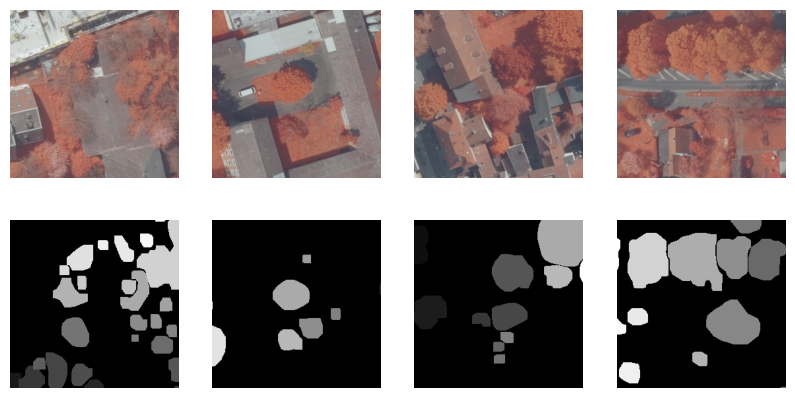

2024-04-23 10:16:50.240942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
import matplotlib.pyplot as plt

for images, masks in train_dataset.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.subplot(2, 4, i+5)
        plt.imshow(masks[i, ..., 0], cmap='gray')
        plt.axis('off')
    plt.show()